In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load('high_dimension_toy_dataset.npy')

In [3]:
dataset.shape

(6000, 16)

In [4]:
X = dataset[:, :-2]
y = dataset[:, -2]
d = dataset[:, -1]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [5]:
X.shape, y.shape, d.shape

((6000, 14), (6000,), (6000,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [8]:
combined_arrays = list(zip(Xt, yt))

# Shuffle the combined arrays
random.shuffle(combined_arrays)

# Unzip the shuffled arrays back into separate arrays
Xt, yt = zip(*combined_arrays)
Xt = torch.stack(Xt, axis=0)
yt = torch.stack(yt, axis=0)

In [9]:
n_samples = 1300
batch_size = 260
n_components = 3

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==n_domains-1)[0], :], y[np.where(d==n_domains-1)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [11]:
range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))

dim_reduction = 3
K_max = 10
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction
OGMM.get_GMM()

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\Online_GMM.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


[[tensor(0.1296),
  tensor(96.0224),
  tensor([-5.5381, -2.9129, -3.5068]),
  tensor([[34.1083,  3.0674, -3.4238],
          [ 3.0674,  0.2962, -0.2896],
          [-3.4238, -0.2896,  0.3872]])],
 [tensor(0.1477),
  tensor(179.4984),
  tensor([29.7989,  4.1183, -2.6227]),
  tensor([[38.4053,  3.4172, -1.3650],
          [ 3.4172,  0.3294, -0.1240],
          [-1.3650, -0.1240,  0.0496]])],
 [tensor(0.0687),
  tensor(186.9211),
  tensor([-5.6715,  7.9514,  3.3824]),
  tensor([[26.9537, 13.3853, -9.6751],
          [13.3853,  6.7773, -4.8227],
          [-9.6751, -4.8227,  5.4563]])],
 [tensor(3.3332e-39),
  tensor(4.6238),
  tensor([29.0884, -7.3303,  0.5274]),
  tensor([[ 3.0971, -0.4591,  0.2600],
          [-0.4591,  3.9344, -0.5457],
          [ 0.2600, -0.5457,  0.5700]])],
 [tensor(0.2140),
  tensor(151.8725),
  tensor([ 17.0001, -10.4409,   1.6981]),
  tensor([[49.8913,  3.7942,  1.8219],
          [ 3.7942,  0.4463,  0.1168],
          [ 1.8219,  0.1168,  0.0792]])],
 [tensor(0.

In [12]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=10, random_state=0)

## Tests on the GMM

In [36]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

-5696.172270828053

In [37]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)
np.sum(sklearn_GMM.score_samples(Xt))

56852.42933904081

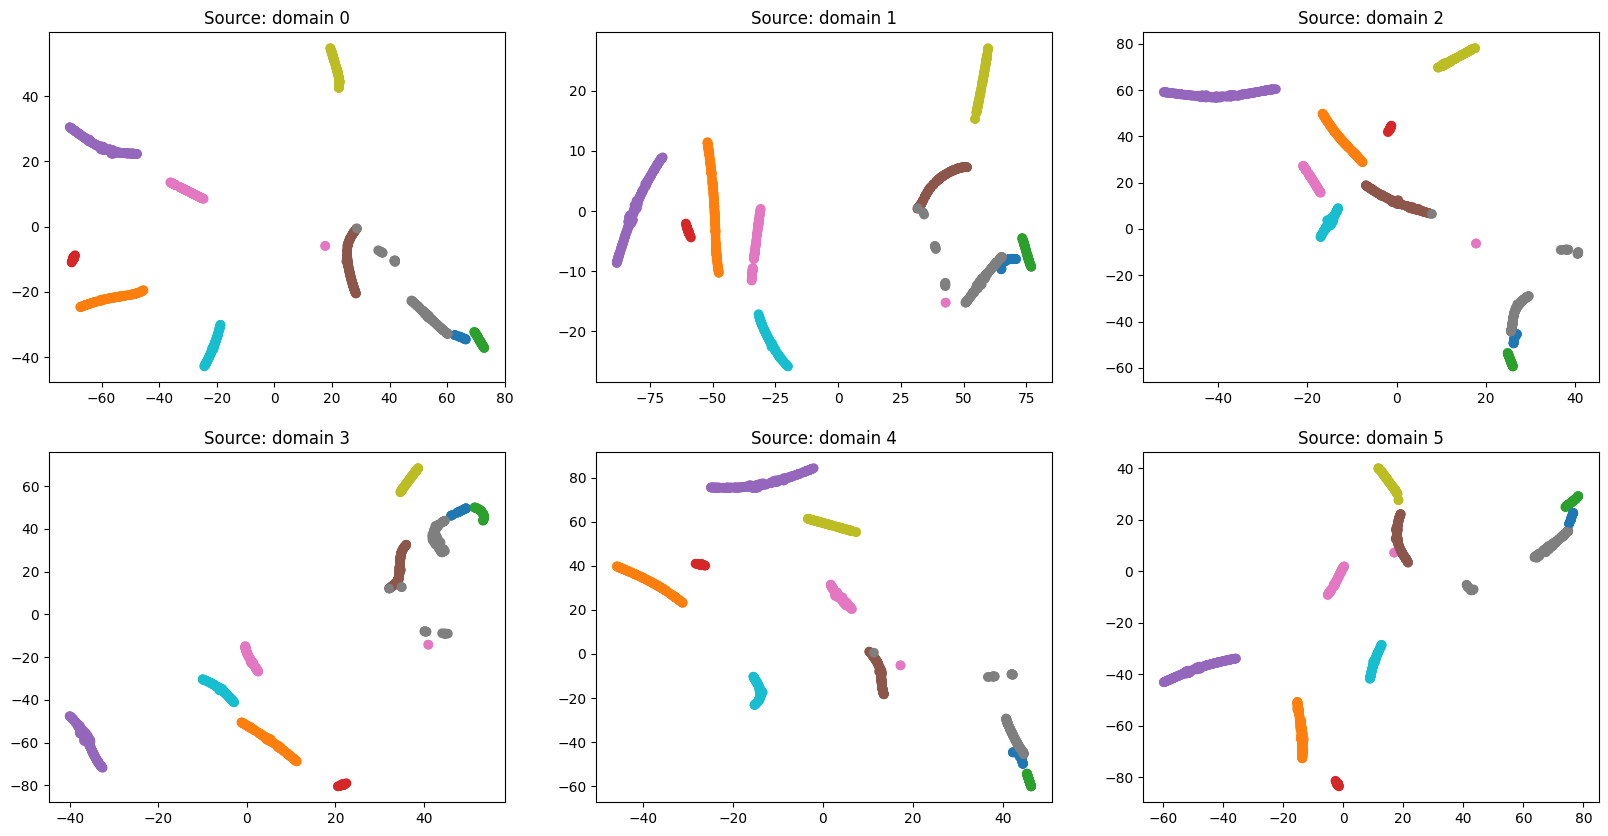

In [38]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')


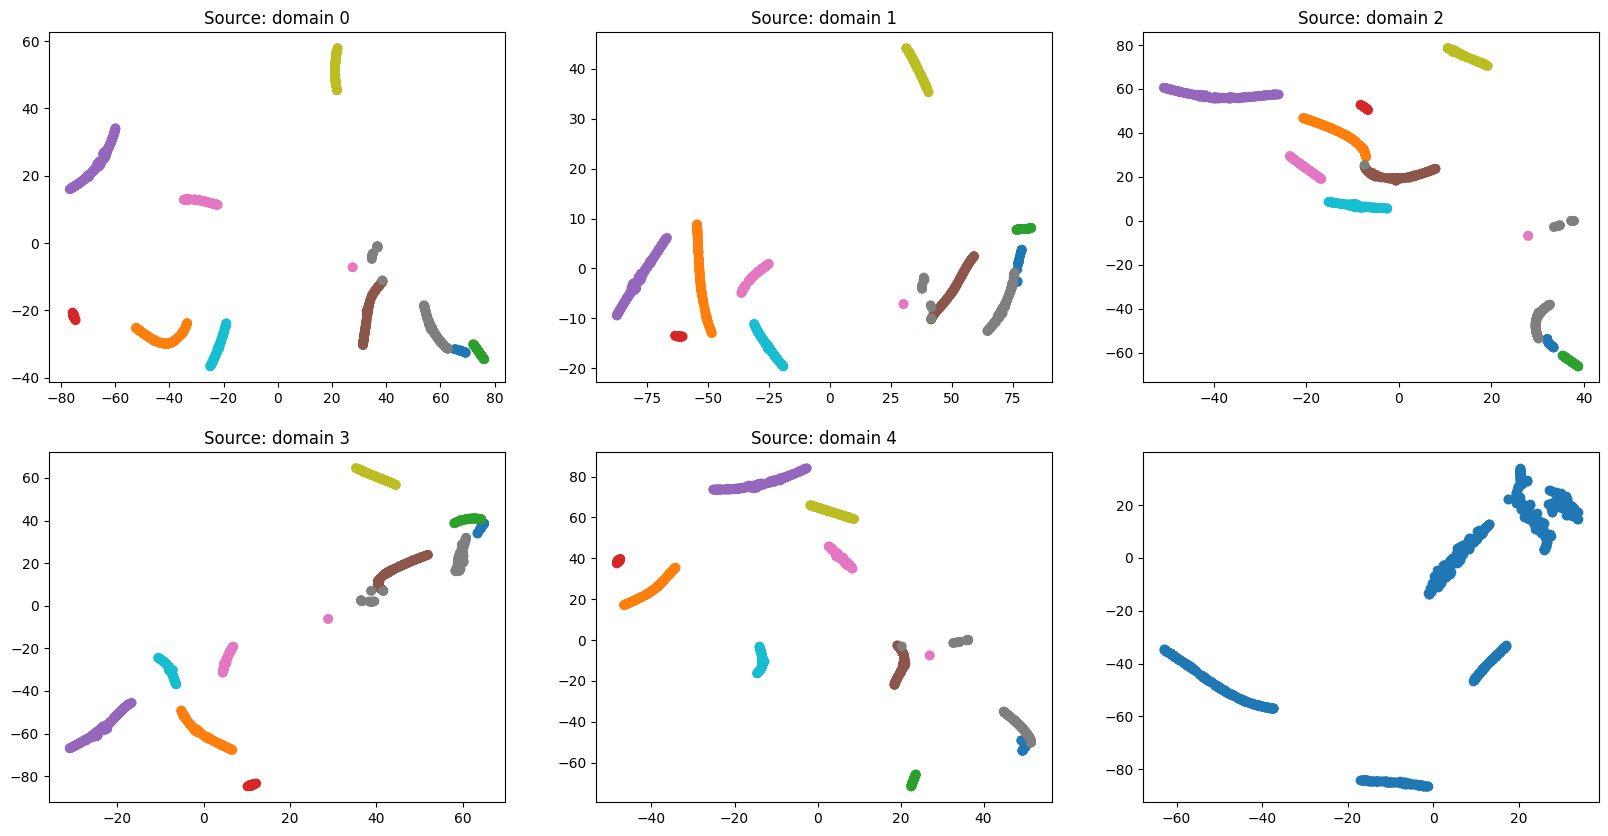

In [39]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

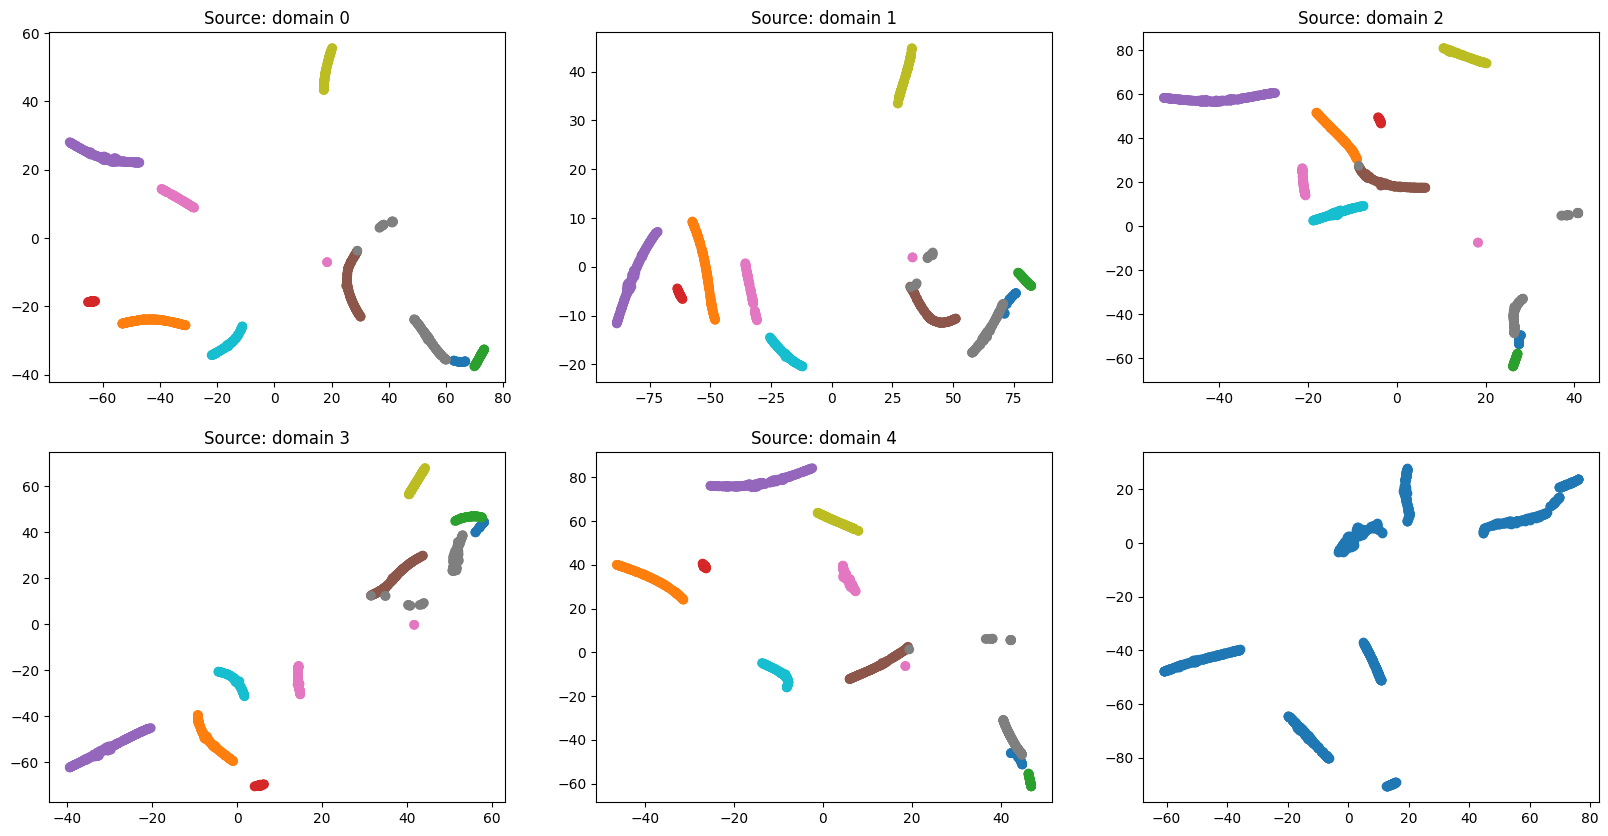

In [40]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(1000)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

Test to determine the best K_max

In [ ]:
#%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(10, 60, 6)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.get_GMM())
    ll.append(OGMM.score_samples(X_test_target_t, dimension_reduction=True))

## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [47]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

In [48]:
criterion = JointWassersteinDistance()

In [49]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=10,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [50]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 14721.4220703125
It 2/40, Loss: 9585.78857421875
It 3/40, Loss: 6007.775390625
It 4/40, Loss: 4273.515234375
It 5/40, Loss: 3514.0781738281253
It 6/40, Loss: 3094.8162597656255
It 7/40, Loss: 2836.54189453125
It 8/40, Loss: 2674.495458984375
It 9/40, Loss: 2553.753173828125
It 10/40, Loss: 2398.357080078125
It 11/40, Loss: 2321.536328125
It 12/40, Loss: 2223.302734375
It 13/40, Loss: 2139.002978515625
It 14/40, Loss: 2046.0343017578125
It 15/40, Loss: 1993.8669677734374
It 16/40, Loss: 1902.9918457031247
It 17/40, Loss: 1891.4139404296875
It 18/40, Loss: 1794.693359375
It 19/40, Loss: 1775.2713623046873
It 20/40, Loss: 1719.9519775390627
It 21/40, Loss: 1694.0260986328126
It 22/40, Loss: 1655.2542724609375
It 23/40, Loss: 1634.1209228515625
It 24/40, Loss: 1577.5065429687502
It 25/40, Loss: 1556.3310791015624
It 26/40, Loss: 1528.737646484375
It 27/40, Loss: 1530.4054931640624
It 28/40, Loss: 1492.1435546875
It 29/40, Loss: 1469.956640625
It 30/40, Loss: 1451.01108398437

In [51]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [52]:
names_sources = [f'domain {i}' for i in range(6)]

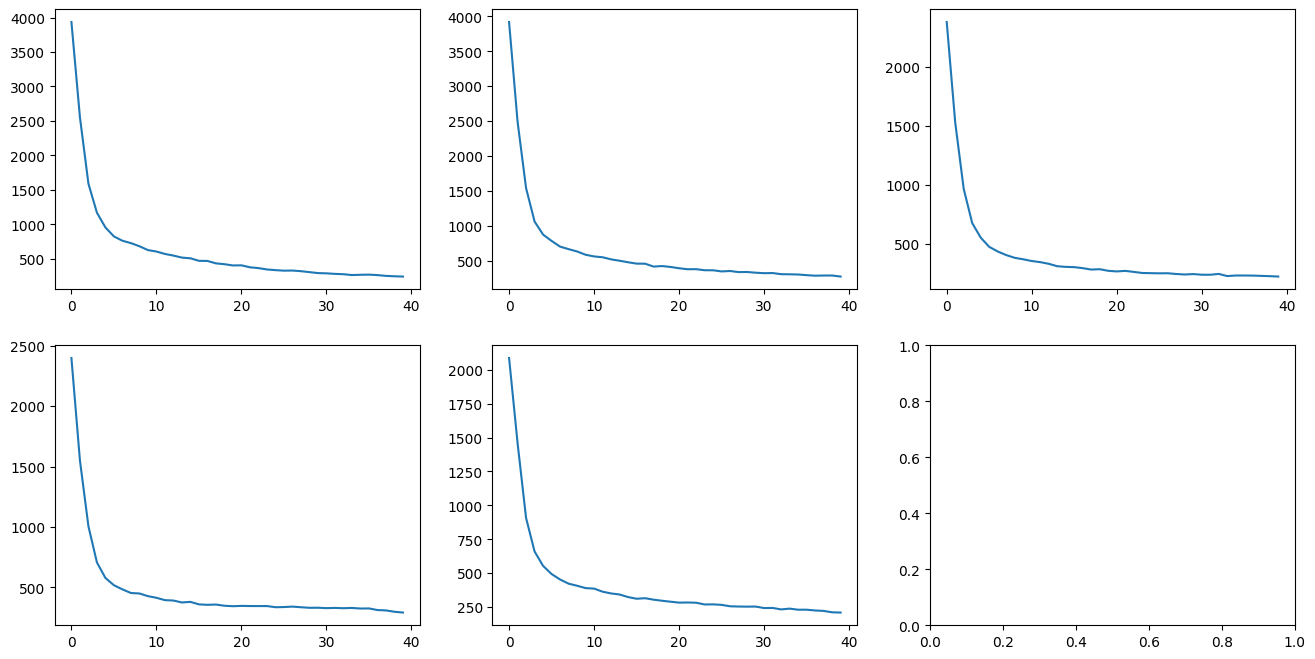

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

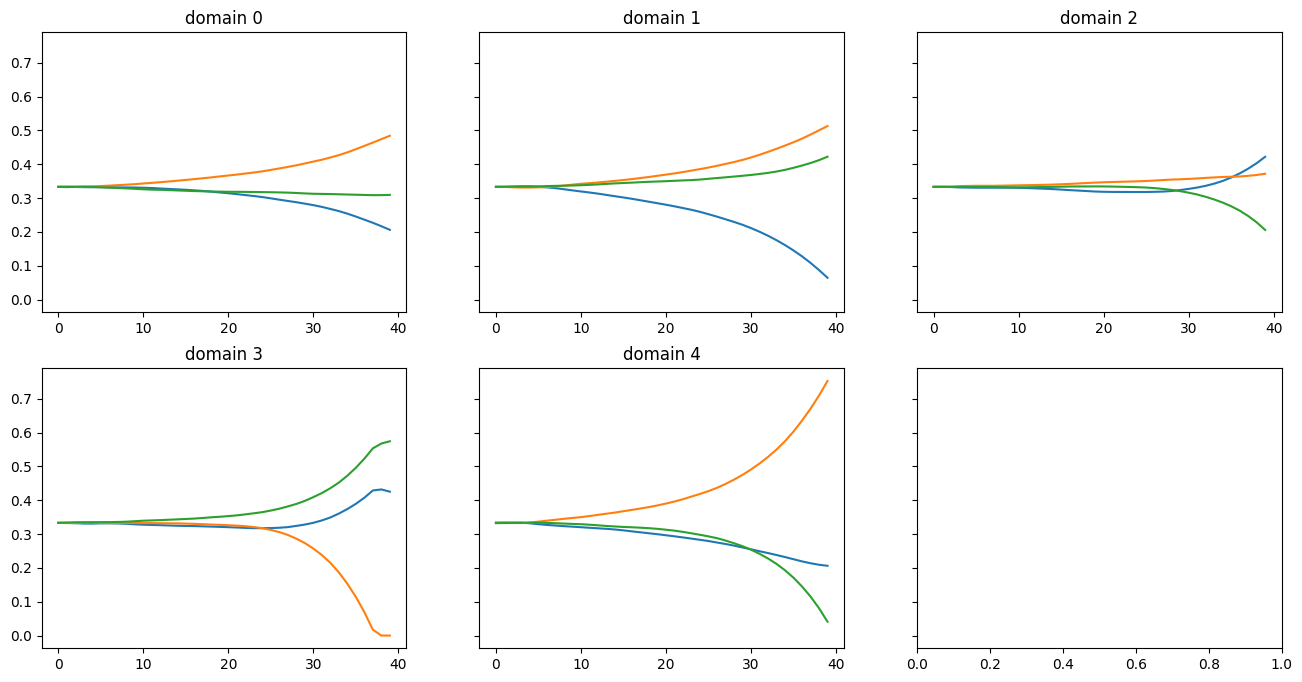

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [56]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=10,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=1,
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False,
                           GMM_components=13,
                           GMM_dim_reduction=dim_reduction)

In [57]:
i = 0
while i < Xt.shape[0]-dim_reduction:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+dim_reduction, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += dim_reduction

0
Loss: 764.9942382812501
3
Loss: 879.9021606445312
6
Loss: 316.96171875
9
Loss: 320.90607299804685
12
Loss: 282.6362731933594
15
Loss: 263.27666625976565
18
Loss: 333.06854248046875
21
Loss: 349.2949035644531
24
Loss: 306.2917724609375
27
Loss: 331.44380493164067
30
Loss: 303.75939331054684
33
Loss: 284.6476806640625
36
Loss: 323.64454956054686
39
Loss: 298.679638671875
42
Loss: 292.7940368652344
45
Loss: 321.1978393554687
48
Loss: 291.8314636230469
51
Loss: 327.7268920898438
54
Loss: 336.6454772949219
57
Loss: 519.5668334960938
60
Loss: 511.4435119628906
63
Loss: 449.43761596679684
66
Loss: 488.26395874023433
69
Loss: 386.34252319335934
72
Loss: 372.6705627441406
75
Loss: 574.762939453125
78
Loss: 429.3861511230469
81
Loss: 489.4678771972656
84
Loss: 609.8569091796875
87
Loss: 715.1913208007812
90
Loss: 652.6509399414062
93
Loss: 561.6962585449219
96
Loss: 444.80157470703125
99
Loss: 445.8962097167969
102
Loss: 496.89054565429683
105
Loss: 362.9239379882813
108
Loss: 395.858203125
11

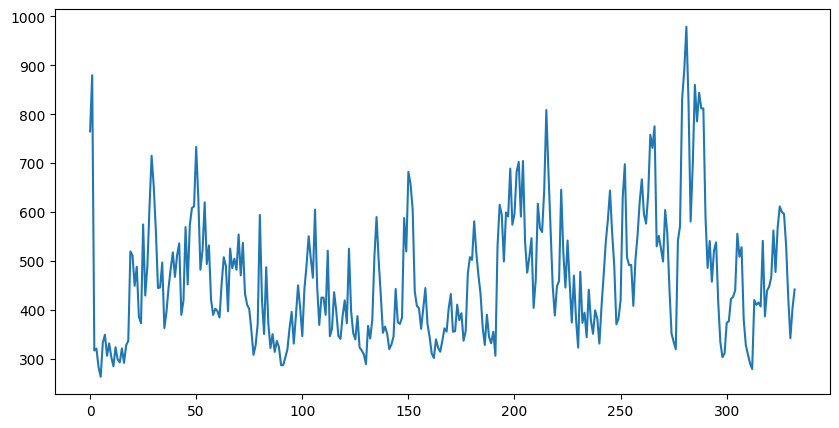

In [58]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

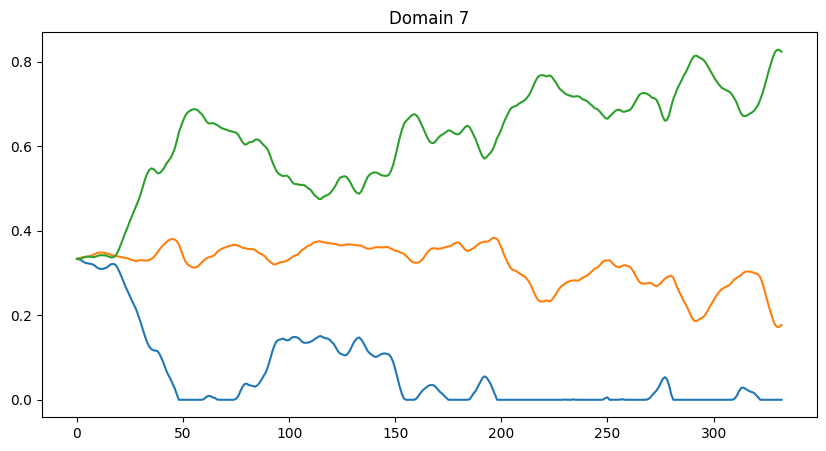

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

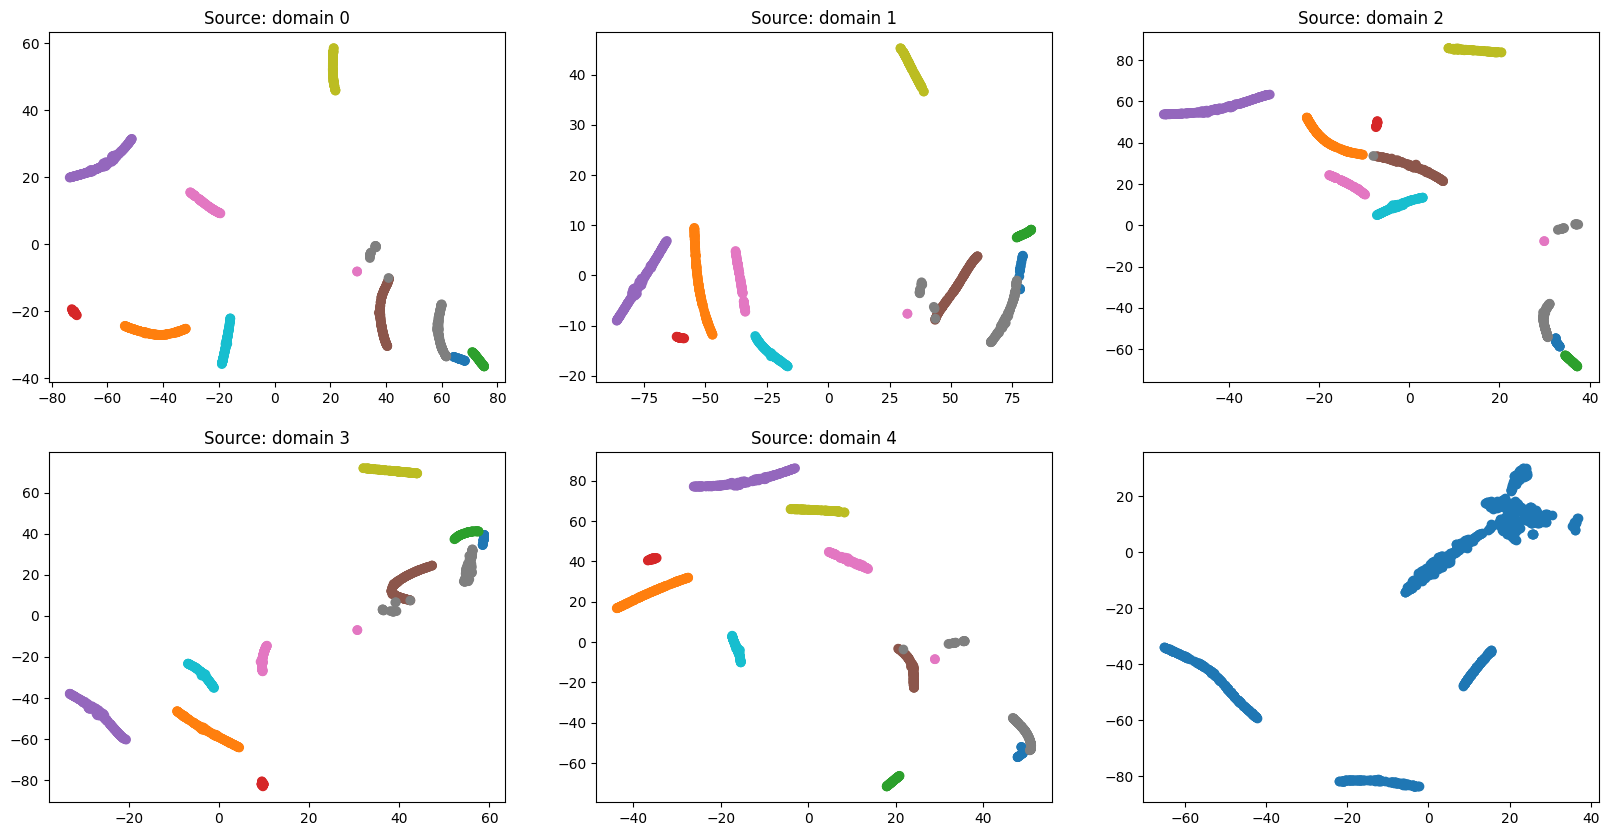

In [63]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

In [64]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.0000, 0.1768, 0.8232])


In [65]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [75]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.648


DaDiL-E

In [74]:
#clf = SVC(kernel='rbf', probability=True)
clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.694
Atom 1 w/ weight 0.1770000010728836 got 0.523
Atom 2 w/ weight 0.8230000138282776 got 0.606
0.632


DaDiL-R

In [78]:
clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.688


## Dictionary learning seperated between sources and target

In [ ]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [ ]:
criterion = JointWassersteinDistance()

In [ ]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 104.57896575927735
It 2/40, Loss: 48.48569030761718
It 3/40, Loss: 20.745359039306642
It 4/40, Loss: 9.587585067749023
It 5/40, Loss: 4.695422554016113
It 6/40, Loss: 2.718421077728271
It 7/40, Loss: 1.870379400253296
It 8/40, Loss: 1.349921202659607
It 9/40, Loss: 1.0536291599273682
It 10/40, Loss: 0.8426506042480469
It 11/40, Loss: 0.6932435393333436
It 12/40, Loss: 0.6030386924743651
It 13/40, Loss: 0.5455300450325012
It 14/40, Loss: 0.5092640280723573
It 15/40, Loss: 0.46095628738403316
It 16/40, Loss: 0.43091865777969357
It 17/40, Loss: 0.39491532444953914
It 18/40, Loss: 0.3542603731155396
It 19/40, Loss: 0.31674467325210576
It 20/40, Loss: 0.26489515900611876
It 21/40, Loss: 0.24053622484207154
It 22/40, Loss: 0.2299456000328064
It 23/40, Loss: 0.21391334533691403
It 24/40, Loss: 0.21284708380699158
It 25/40, Loss: 0.20963108539581296
It 26/40, Loss: 0.2177614390850067
It 27/40, Loss: 0.21479105651378633
It 28/40, Loss: 0.20286512970924375
It 29/40, Loss: 0.214636

In [ ]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [ ]:
names_sources = [f'domain {i}' for i in range(6)]

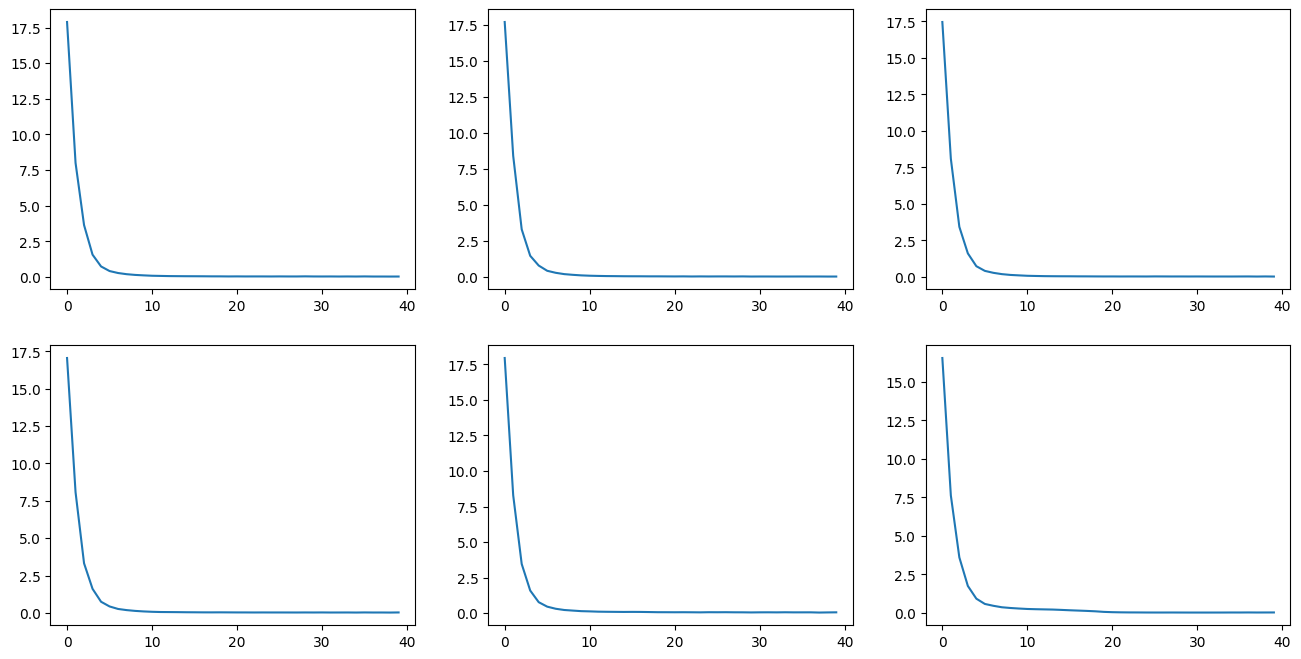

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

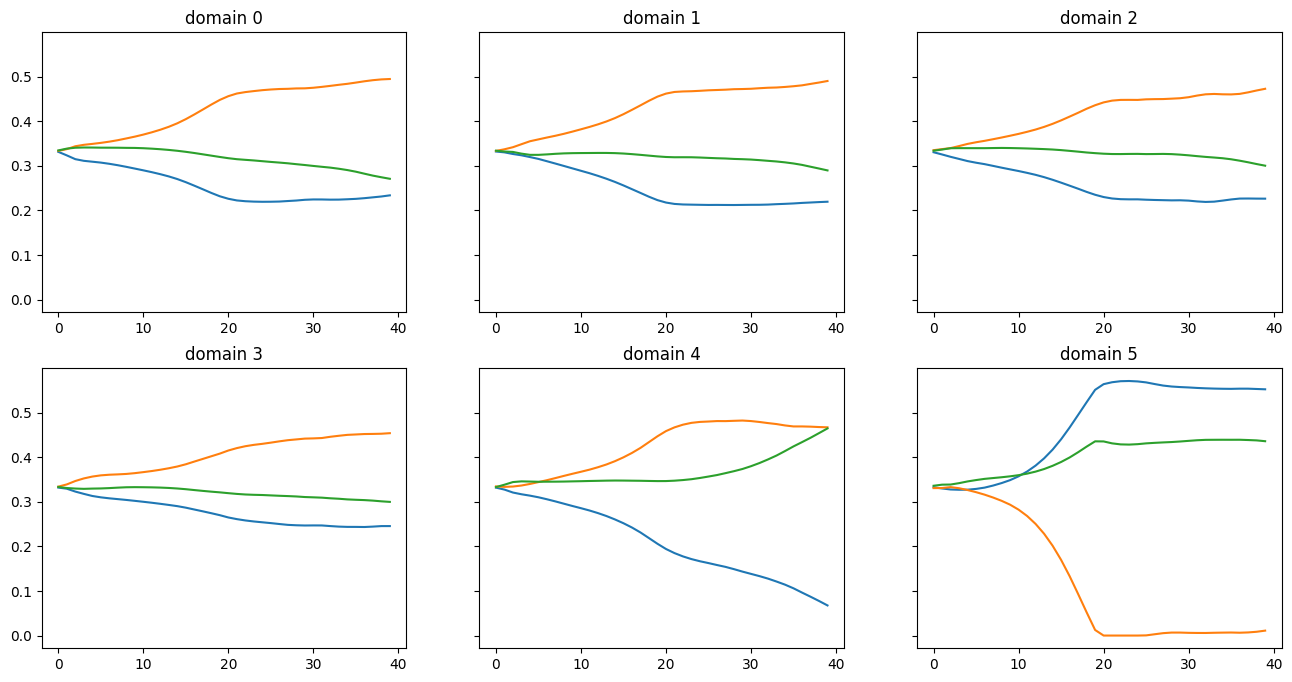

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [ ]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 0.16644451022148132
It 2/40, Loss: 0.15179737508296967
It 3/40, Loss: 0.1576697826385498
It 4/40, Loss: 0.15708852708339693
It 5/40, Loss: 0.16109951734542843
It 6/40, Loss: 0.15686920285224912
It 7/40, Loss: 0.15914348065853118
It 8/40, Loss: 0.16173571348190308
It 9/40, Loss: 0.16527546048164368
It 10/40, Loss: 0.15878852307796482
It 11/40, Loss: 0.16121326386928558
It 12/40, Loss: 0.15778304040431976
It 13/40, Loss: 0.15548029243946074
It 14/40, Loss: 0.15469980239868164
It 15/40, Loss: 0.16221418976783752
It 16/40, Loss: 0.16227197349071504
It 17/40, Loss: 0.1584113419055939
It 18/40, Loss: 0.16074424684047697
It 19/40, Loss: 0.15753774940967558
It 20/40, Loss: 0.15285910665988922
It 21/40, Loss: 0.15727139115333558
It 22/40, Loss: 0.16209094524383544
It 23/40, Loss: 0.15863287448883057
It 24/40, Loss: 0.15747550427913667
It 25/40, Loss: 0.16778385639190674
It 26/40, Loss: 0.15736677944660188
It 27/40, Loss: 0.16108661890029907
It 28/40, Loss: 0.16081570088863373
It 

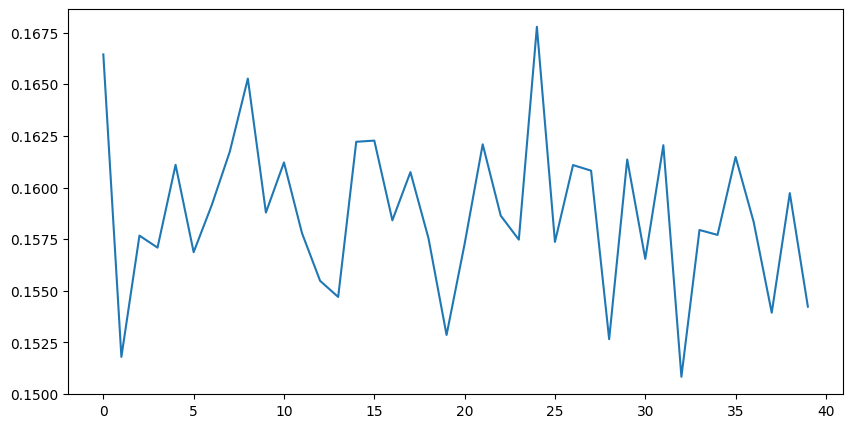

In [ ]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

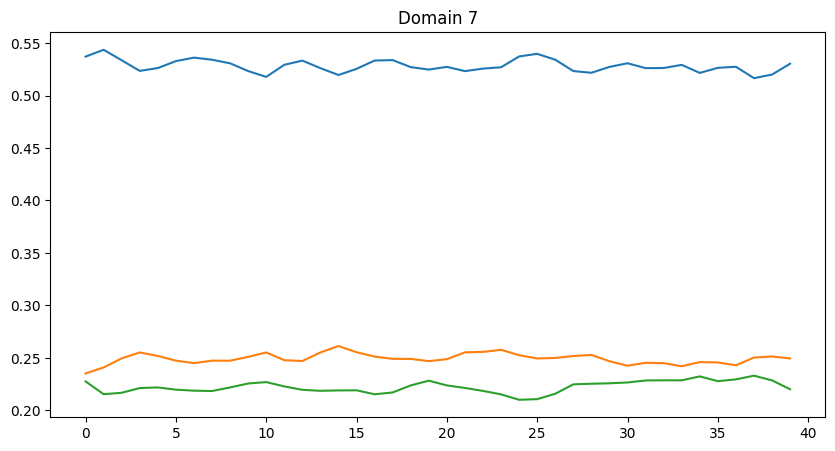

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [ ]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.5303, 0.2495, 0.2202])


In [ ]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [ ]:
#clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion = 'gini')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8384615384615385


DaDiL-E

In [ ]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.5299999713897705 got 0.5576923076923077
Atom 1 w/ weight 0.25 got 0.3769230769230769
Atom 2 w/ weight 0.2199999988079071 got 0.4807692307692308
0.5538461538461539


DaDiL-R

In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6115384615384616


## Classic Dictionary learning with Online_GMM

In [13]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [14]:
criterion = JointWassersteinDistance()

In [15]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=10,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [16]:
dictionary.fit(Q,
               n_iter_max=80,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=False)

It 1/80, Loss: 15348.634374999998
It 2/80, Loss: 10193.0439453125
It 3/80, Loss: 6483.2875
It 4/80, Loss: 4792.0947265625
It 5/80, Loss: 3936.67958984375
It 6/80, Loss: 3581.0041992187503
It 7/80, Loss: 3313.9380859375005
It 8/80, Loss: 3148.8267578125
It 9/80, Loss: 2958.799755859375
It 10/80, Loss: 2824.91357421875
It 11/80, Loss: 2770.446533203125
It 12/80, Loss: 2646.56552734375
It 13/80, Loss: 2550.42607421875
It 14/80, Loss: 2467.235498046875
It 15/80, Loss: 2376.78232421875
It 16/80, Loss: 2316.146923828125
It 17/80, Loss: 2260.928369140625
It 18/80, Loss: 2192.470703125
It 19/80, Loss: 2131.869384765625
It 20/80, Loss: 2111.42958984375
It 21/80, Loss: 2035.6667968749998
It 22/80, Loss: 1980.6721191406248
It 23/80, Loss: 2004.3939697265625
It 24/80, Loss: 1975.286279296875
It 25/80, Loss: 1961.0416015625
It 26/80, Loss: 1907.10703125
It 27/80, Loss: 1848.4262695312498
It 28/80, Loss: 1834.5763671875002
It 29/80, Loss: 1781.249462890625
It 30/80, Loss: 1780.570263671875
It 31/80,

In [17]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

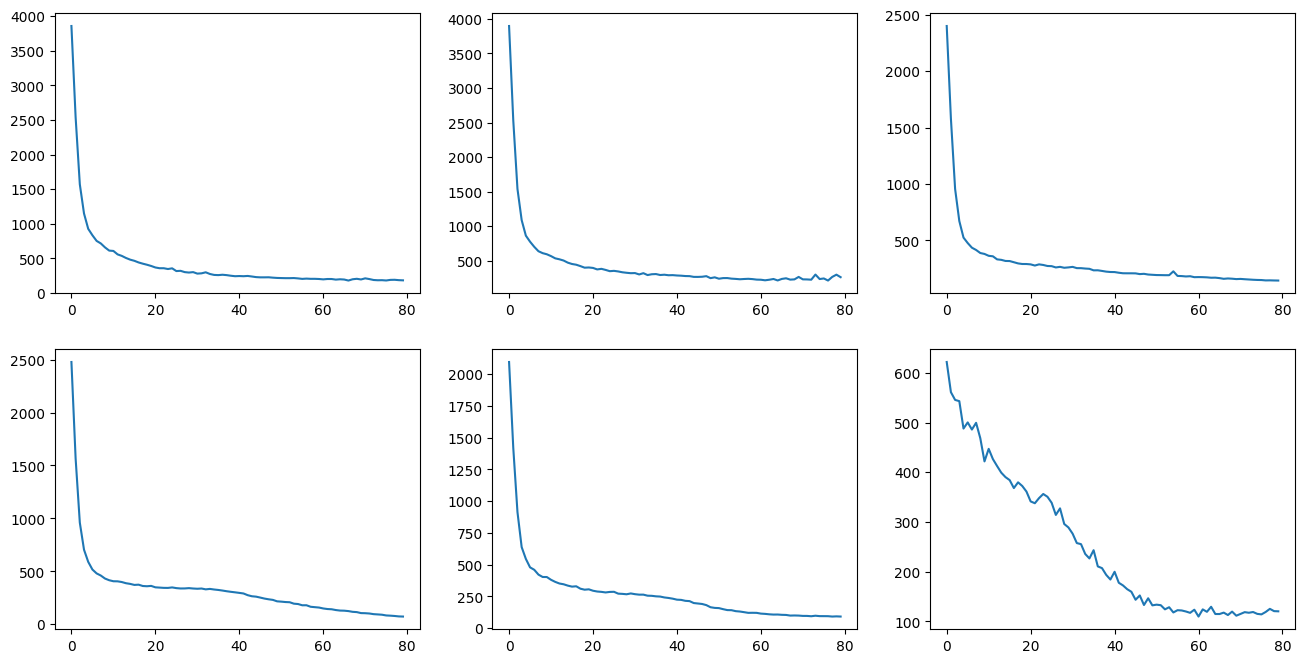

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

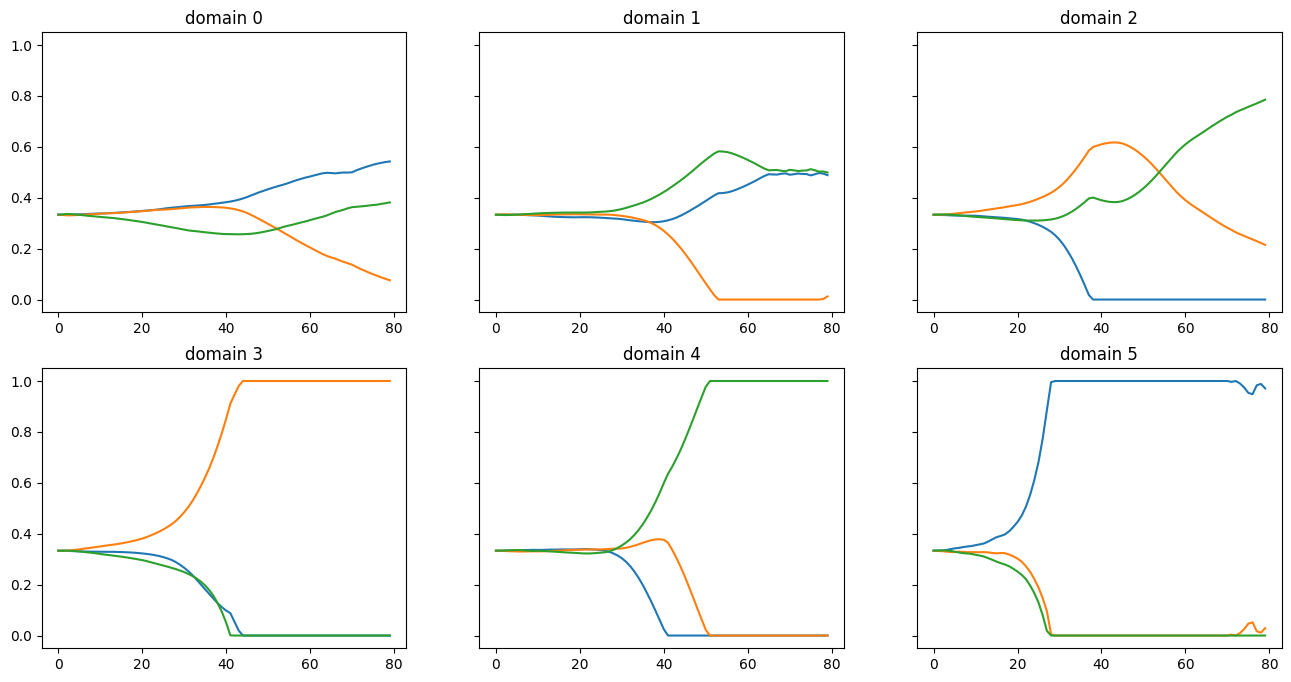

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [20]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.9710, 0.0290, 0.0000])


In [21]:
Xr, Yr = dictionary.reconstruct(weights=weights)

Classification without DA

In [22]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.648


DaDiL-E

In [23]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.9710000157356262 got 0.809
Atom 1 w/ weight 0.028999999165534973 got 0.524
Atom 2 w/ weight 0.0 got 0.457
0.914


DaDiL-R

In [24]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.963


Final optimal transport to adapt domains

In [25]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.9710000157356262 got 0.696
Atom 1 w/ weight 0.028999999165534973 got 0.65
Atom 2 w/ weight 0.0 got 0.73
0.73


In [26]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.676


## Classic Dictionary Learning

In [27]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [28]:
criterion = JointWassersteinDistance()

In [29]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=10,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [30]:
dictionary.fit(Q,
               n_iter_max=80,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/80, Loss: 15456.586132812501
It 2/80, Loss: 10292.945703125
It 3/80, Loss: 6690.96103515625
It 4/80, Loss: 4873.5130859375
It 5/80, Loss: 4084.3591796875
It 6/80, Loss: 3576.19638671875
It 7/80, Loss: 3302.4312011718753
It 8/80, Loss: 3121.583544921875
It 9/80, Loss: 2980.3438964843745
It 10/80, Loss: 2851.9398437500004
It 11/80, Loss: 2705.135546875
It 12/80, Loss: 2608.421923828125
It 13/80, Loss: 2531.292724609375
It 14/80, Loss: 2465.473583984375
It 15/80, Loss: 2395.976708984375
It 16/80, Loss: 2315.972607421875
It 17/80, Loss: 2223.38212890625
It 18/80, Loss: 2179.66142578125
It 19/80, Loss: 2171.018896484375
It 20/80, Loss: 2121.5915039062497
It 21/80, Loss: 2118.036181640625
It 22/80, Loss: 2018.1250244140624
It 23/80, Loss: 2001.6453125
It 24/80, Loss: 1945.381982421875
It 25/80, Loss: 1959.96767578125
It 26/80, Loss: 1930.9030517578124
It 27/80, Loss: 1893.2579589843751
It 28/80, Loss: 1880.6989990234374
It 29/80, Loss: 1832.795556640625
It 30/80, Loss: 1809.828833007812

In [31]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

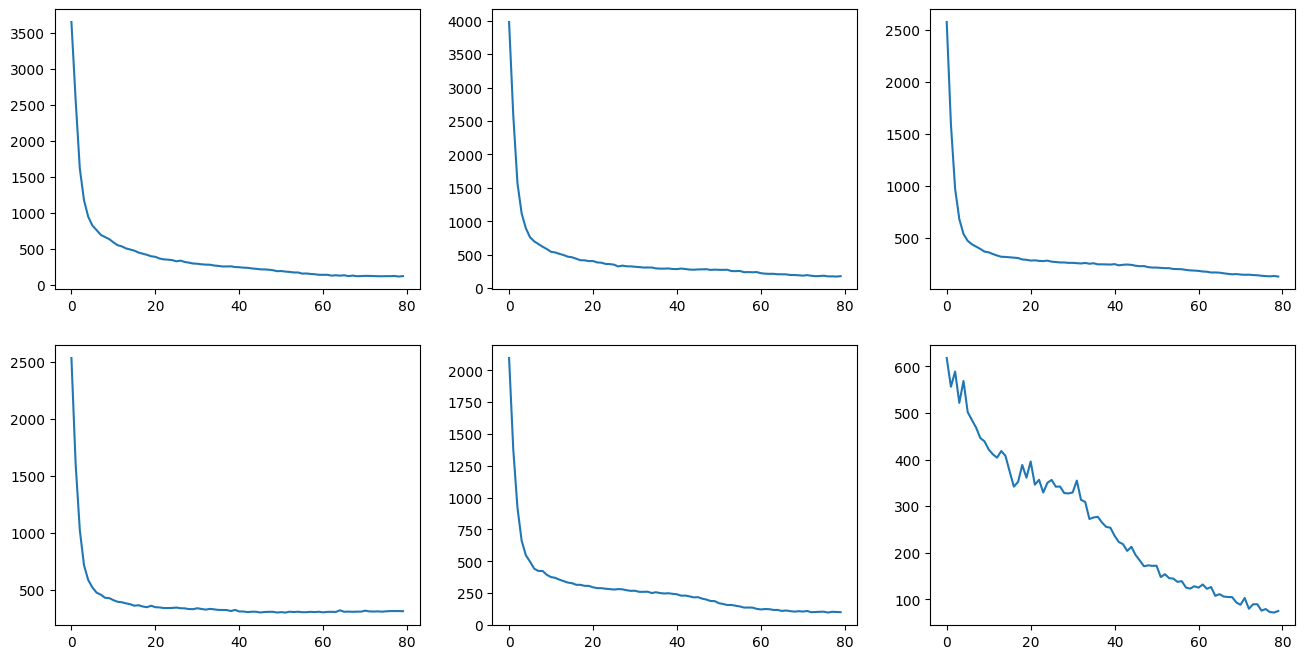

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

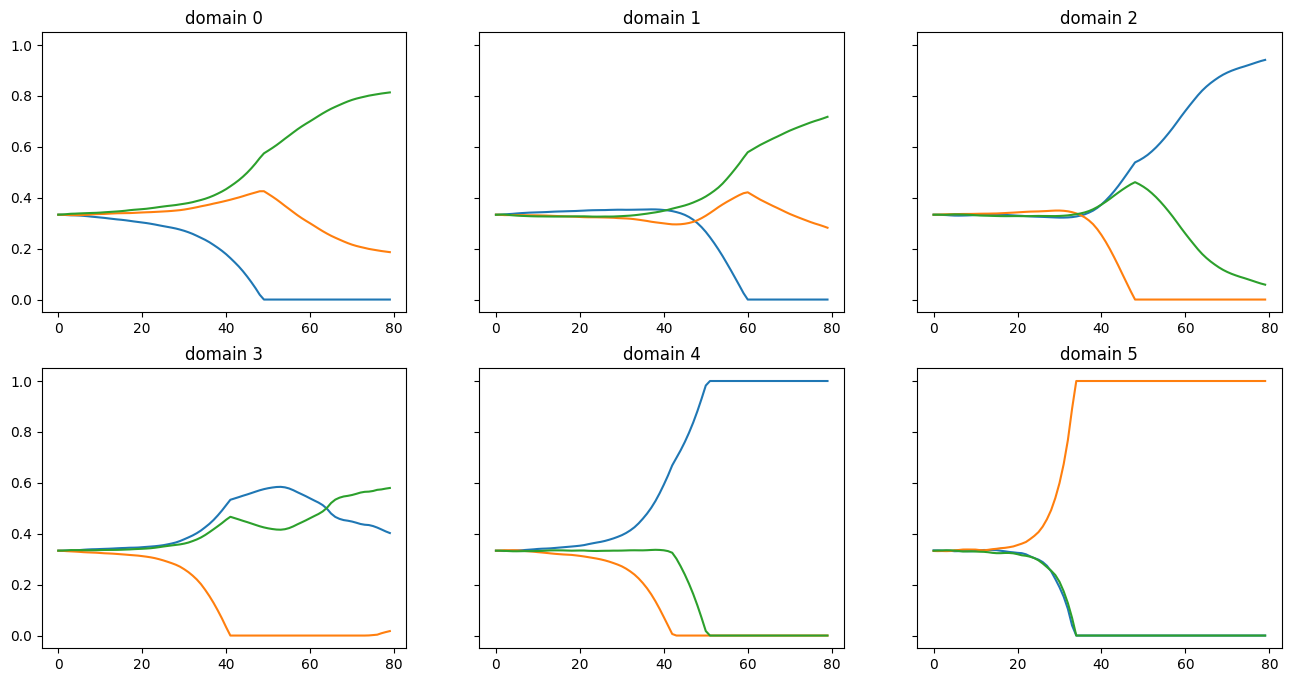

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [34]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0., 1., 0.])


In [35]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [36]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.648


DaDiL-E

In [41]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.511
Atom 1 w/ weight 1.0 got 0.835
Atom 2 w/ weight 0.0 got 0.494
0.812


DaDiL-R

In [45]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.835
